# Evaluation
This code contains all the necessary code to perform the necessary evaluations of the individual parts.

In [152]:
file_output_exercise1 = "../output.txt"
file_output_exercise2_rdd = "../output_rdd.txt"
file_output_exercise2_ds = "../output_ds.txt"
file_grid_search_evaluation = "../grid_search_evaluation.csv"

## Load results

In [153]:
def parse_file(file_path):
    category_terms = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()    

    merged_dict = None

    for line in lines:
        if line.startswith('<'):
            line_splitted = line.split(' ')
            category = line_splitted[0].replace('<', '').replace('>', '')
            terms = line_splitted[1:]
            for term_chisquared in terms:
                term, chi_squared = term_chisquared.split(':', 2)
                if category not in category_terms:
                    category_terms[category] = {}

                category_terms[category][term] = float(chi_squared)
        else:

            merged_dict = line.split(' ')
                
       
    return category_terms, merged_dict

In [154]:
chi_squared_ex1, merged_dict_ex1 = parse_file(file_output_exercise1)
chi_squared_ex2_rdd, merged_dict_ex2_rdd = parse_file(file_output_exercise2_rdd)
_, merged_dict_ex2_ds = parse_file(file_output_exercise2_ds)

## Part 1

In [155]:
from collections import defaultdict

def compareResults(chi_squared1, chi_squared2):
    result = {}
    missing_categories = defaultdict(list)
    for category in chi_squared1:
        result[category] = {}

        for term in chi_squared1[category]:
            result[category][term] = True
            if term in chi_squared2[category]:
                result[category][term] &= abs(chi_squared1[category][term] - chi_squared2[category][term]) < 0.001
            else:
                result[category][term] &= False
                missing_categories[category].append(((term, chi_squared1[category][term]), 'mapreduce'))

    for category in chi_squared2:
        for term in chi_squared2[category]:
            if term not in chi_squared1[category]:
                result[category][term] = False
                missing_categories[category].append(((term, chi_squared2[category][term]), 'rdd'))

    return result, missing_categories


In [156]:
result, missing_categories = compareResults(chi_squared_ex1, chi_squared_ex2_rdd)

In [157]:
def print_results(result):
    cnt = 0
    for category, term_difference in result.items():
        for term, is_different in term_difference.items():
            if is_different == False:
                cnt += 1
                print(f"Category: {category} Term: {term}")

    print(f"Total of different terms: {cnt}")

print_results(result)

Category: Apps_for_Android Term: devs
Category: Apps_for_Android Term: glu
Category: Apps_for_Android Term: teamlava
Category: Apps_for_Android Term: zynga
Category: Tools_and_Home_Improvement Term: bidet
Category: Tools_and_Home_Improvement Term: kidde
Total of different terms: 6


In [158]:
missing_categories

defaultdict(list,
            {'Apps_for_Android': [(('devs', 86.64962060177764), 'mapreduce'),
              (('glu', 86.64962060177764), 'mapreduce'),
              (('teamlava', 86.64962060177764), 'rdd'),
              (('zynga', 86.64962060177764), 'rdd')],
             'Tools_and_Home_Improvement': [(('bidet', 159.72357729489363),
               'mapreduce'),
              (('kidde', 159.72357729489363), 'rdd')]})

## Part 2

In [159]:
def containsAll(merged_dict_rdd, merged_dict_ds):
    not_contained = []
    for term in merged_dict_rdd:
        if term not in merged_dict_ds:
            not_contained.append(term)

    return not_contained

In [166]:
result = containsAll(merged_dict_ex2_rdd, merged_dict_ex2_ds)

In [168]:
len(merged_dict_ex2_rdd), len(merged_dict_ex2_ds), len(result)

(1464, 2000, 1250)

## Part 3

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(file_grid_search_evaluation)
df.columns = df.columns.str.strip() 

df["maxIter"] = df["maxIter"].astype(str)
df["NumTopFeatures"] = df["NumTopFeatures"].astype(str)
df["regParam"] = df["regParam"].astype(str)
df["standardization"] = df["standardization"].astype(str)

In [ ]:
df

,maxIter,NumTopFeatures,regParam,standardization,f1-score
0,10,20,0.001,False,0.244530
1,50,20,0.001,False,0.253933
2,10,20,0.001,True,0.247545
3,50,20,0.001,True,0.239803
4,10,2000,0.001,False,0.399768
5,50,2000,0.001,False,0.451065
6,10,2000,0.001,True,0.430844
7,50,2000,0.001,True,0.422536
8,10,20,0.01,False,0.230873
9,50,20,0.01,False,0.255260


[Text(0.5, 0, 'Model'), Text(0, 0.5, 'F1-Score')]

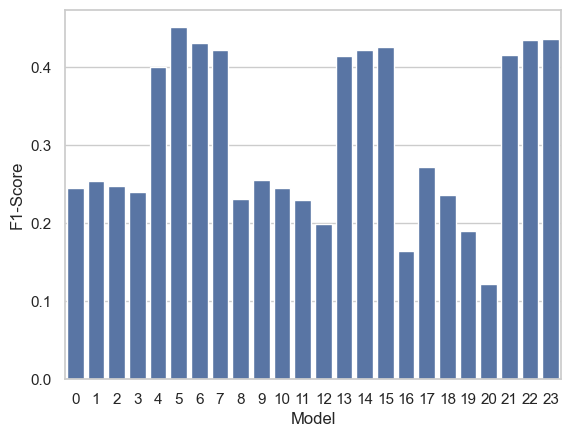

In [ ]:
ax = sns.barplot(df, x=df.index, y="f1-score", fill="f1-score")
ax.set(xlabel="Model",ylabel="F1-Score")

In [ ]:
df[df["f1-score"] > .3]

,maxIter,NumTopFeatures,regParam,standardization,f1-score
4,10,2000,0.001,False,0.399768
5,50,2000,0.001,False,0.451065
6,10,2000,0.001,True,0.430844
7,50,2000,0.001,True,0.422536
13,50,2000,0.01,False,0.413916
14,10,2000,0.01,True,0.422287
15,50,2000,0.01,True,0.426214
21,50,2000,0.1,False,0.415682
22,10,2000,0.1,True,0.435021
23,50,2000,0.1,True,0.435813


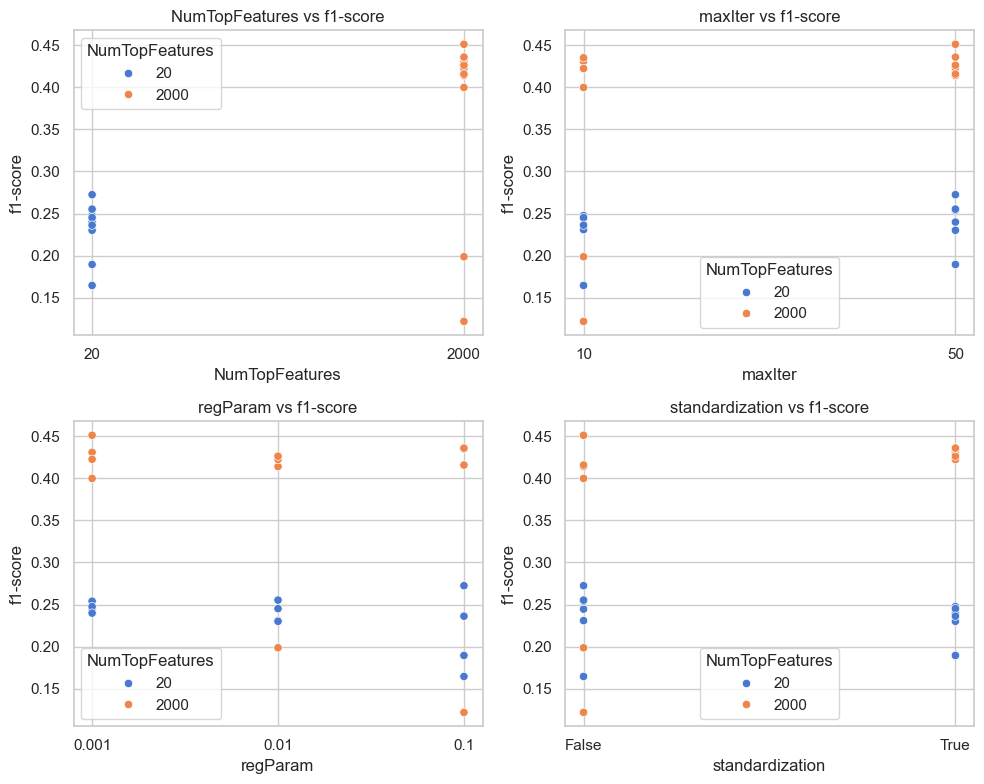

In [ ]:
palette_name = "muted"
columns = ['NumTopFeatures', 'maxIter', 'regParam', 'standardization']
titles = ['NumTopFeatures vs f1-score', 'maxIter vs f1-score', 'regParam vs f1-score', 'standardization vs f1-score']


fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, col in enumerate(columns):
    row_index = i // 2
    col_index = i % 2
    
    sns.scatterplot(data=df, x=col, y='f1-score', hue='NumTopFeatures', palette=palette_name, ax=axs[row_index, col_index])
    
    axs[row_index, col_index].set_title(titles[i])
    axs[row_index, col_index].set_xlabel(col)
    axs[row_index, col_index].set_ylabel('f1-score')

plt.tight_layout()
plt.show()
